# Source layouts schematics

In [1]:
from IPython.display import display  # noqa: F401  # ignore used but not imported
from pathlib import Path
import numpy as np
import pandas as pd
import verde as vd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import boost_and_layouts
from boost_and_layouts import save_to_json


## Define parameters for building the source distributions

In [2]:
# Define results directory to read synthetic ground survey
results_dir = Path("..") / "results"
ground_results_dir = results_dir / "ground_survey"

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Read synthetic ground survey


Get coordinates of observation points from a synthetic ground survey

In [3]:
survey = pd.read_csv(ground_results_dir / "survey.csv")

In [4]:
inside = np.logical_and(
    np.logical_and(
        survey.easting > 0,
        survey.easting < 40e3,
    ),
    np.logical_and(
        survey.northing > -60e3,
        survey.northing < -20e3,
    ),
)
survey = survey.loc[inside]

In [5]:
survey

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,longitude,latitude,height,easting,northing,g_z
2,0.090262,-0.495021,1222.2,10047.939057,-54737.323605,5.131214
3,0.098003,-0.480089,1228.6,10909.643639,-53086.080028,5.660173
4,0.108739,-0.472872,1232.9,12104.722997,-52288.035325,8.411492
5,0.128963,-0.470632,1229.9,14356.128428,-52040.349368,7.872729
6,0.187891,-0.481334,1199.7,20915.890003,-53223.793601,6.166035
...,...,...,...,...,...,...
293,0.325718,-0.251369,1478.3,36258.801093,-27795.031515,11.328018
294,0.335456,-0.265555,1463.9,37342.811116,-29363.671532,10.365876
295,0.340199,-0.224987,1490.5,37870.807382,-24877.860961,10.455458
296,0.356679,-0.285714,1388.4,39705.285882,-31592.794717,10.958459


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


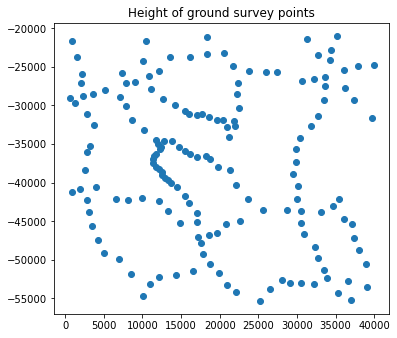

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.scatter(survey.easting, survey.northing)
ax.set_aspect("equal")
ax.set_title("Height of ground survey points")
plt.show()

In [7]:
coordinates = (survey.easting, survey.northing, survey.height)

### Generate the source distributions

In [8]:
block_spacing = 3000
grid_spacing = 2000

layouts = ["source_below_data", "grid_sources", "block_averaged_sources"]
depth_type = "constant_depth"

parameters = {}

layout = "source_below_data"
parameters[layout] = dict(
    depth_type=depth_type,
    depth=500,
)

layout = "grid_sources"
parameters[layout] = dict(depth_type=depth_type, depth=500, spacing=grid_spacing)

layout = "block_averaged_sources"
parameters[layout] = dict(depth_type=depth_type, depth=500, spacing=block_spacing)

In [9]:
source_distributions = {}
for layout in parameters:
    source_distributions[layout] = getattr(boost_and_layouts, layout)(
        coordinates, **parameters[layout]
    )

Create lines for plotting the boundaries of the blocks

In [10]:
region = vd.get_region(coordinates)
grid_nodes = vd.grid_coordinates(region, spacing=block_spacing)

grid_lines = (np.unique(grid_nodes[0]), np.unique(grid_nodes[1]))
for nodes in grid_lines:
    nodes.sort()

## Plot observation points and source layouts

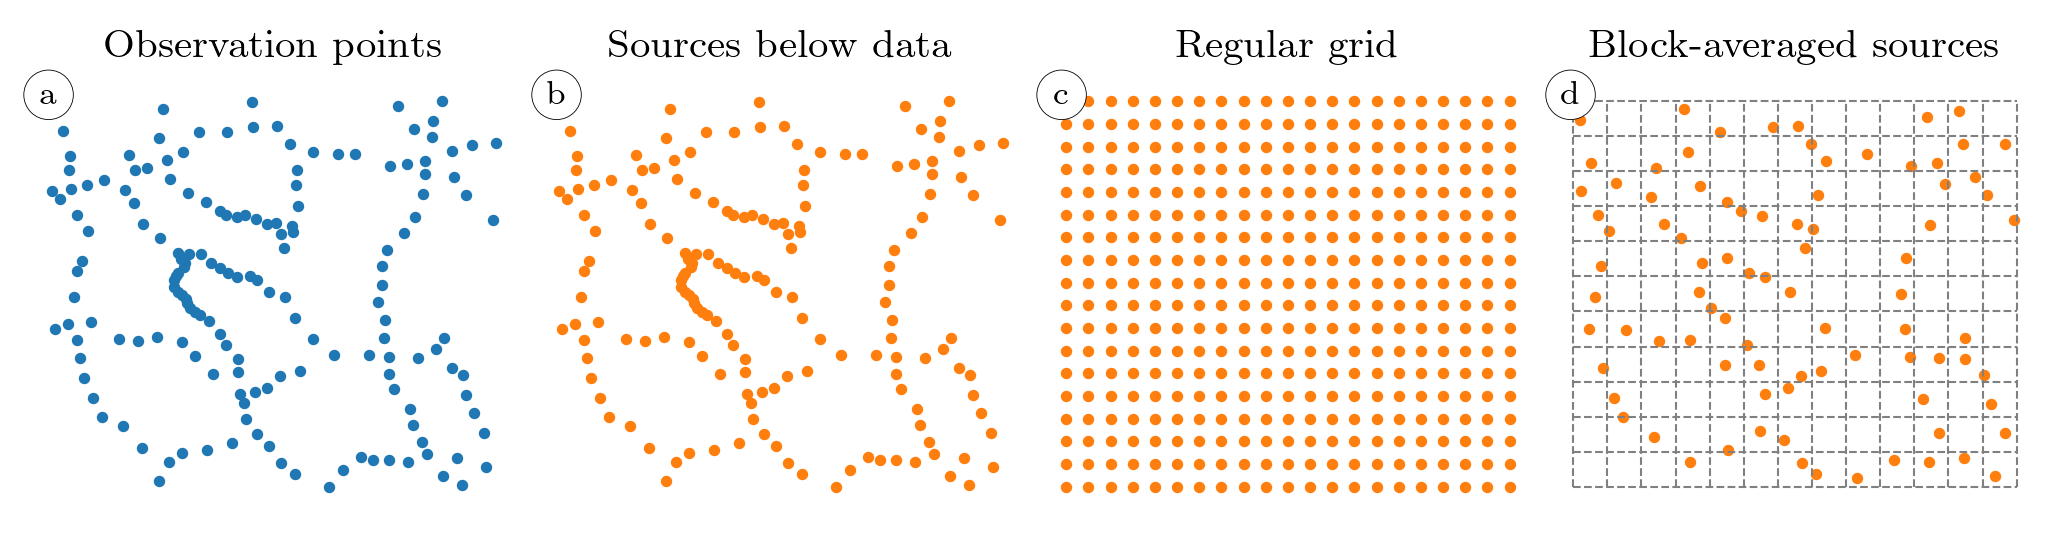

In [11]:
# Load matplotlib configuration
plt.style.use(Path(".") / "matplotlib.rc")

titles = {
    "source_below_data": "Sources below data",
    "block_averaged_sources": "Block-averaged sources",
    "grid_sources": "Regular grid",
}

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(7, 1.7), dpi=300)
size = 3
labels = "a b c d".split()

for ax, label in zip(axes, labels):
    ax.set_aspect("equal")
    ax.annotate(
        label,
        xy=(0.02, 0.95),
        xycoords="axes fraction",
        bbox=dict(boxstyle="circle", fc="white", lw=0.2),
    )
    ax.axis("off")

# Plot observation points
ax = axes[0]
ax.scatter(survey.easting, survey.northing, s=size, c="C0")
ax.set_title("Observation points")

# Plot location of sources for each source layout
for ax, layout in zip(axes[1:], layouts):
    ax.scatter(*source_distributions[layout][:2], s=size, c="C1")
    ax.set_title(titles[layout])

# Add blocks boundaries to Block Averaged Sources plot
ax = axes[3]
grid_style = dict(color="grey", linewidth=0.5, linestyle="--")
xmin, xmax, ymin, ymax = region[:]
for x in grid_lines[0]:
    ax.plot((x, x), (ymin, ymax), **grid_style)
for y in grid_lines[1]:
    ax.plot((xmin, xmax), (y, y), **grid_style)

plt.tight_layout(w_pad=0)
plt.savefig(
    Path("..") / "manuscript" / "figs" / "source-layouts-schematics.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Dump number of observation points and sources to JSON file

In [12]:
variables = {
    "source_layouts_schematics_observations": survey.easting.size,
}
for layout in layouts:
    variables["source_layouts_schematics_{}".format(layout)] = source_distributions[
        layout
    ][0].size

json_file = results_dir / "source-layouts-schematics.json"
save_to_json(variables, json_file)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Gradient boosting schematics

In [13]:
sources = source_distributions["source_below_data"]
region = vd.get_region(sources)

In [14]:
overlapping = 0.5
window_size = 18e3
spacing = window_size * (1 - overlapping)

centers, indices = vd.rolling_window(sources, size=window_size, spacing=spacing)
spacing_easting = centers[0][0, 1] - centers[0][0, 0]
spacing_northing = centers[1][1, 0] - centers[1][0, 0]

print("Desired spacing:", spacing)
print("Actual spacing:", (spacing_easting, spacing_northing))

Desired spacing: 9000.0
Actual spacing: (10706.71851509116, 8131.3595158957105)


In [15]:
indices = [i[0] for i in indices.ravel()]
centers = [i.ravel() for i in centers]
n_windows = centers[0].size

print("Number of windows:", n_windows)

Number of windows: 9


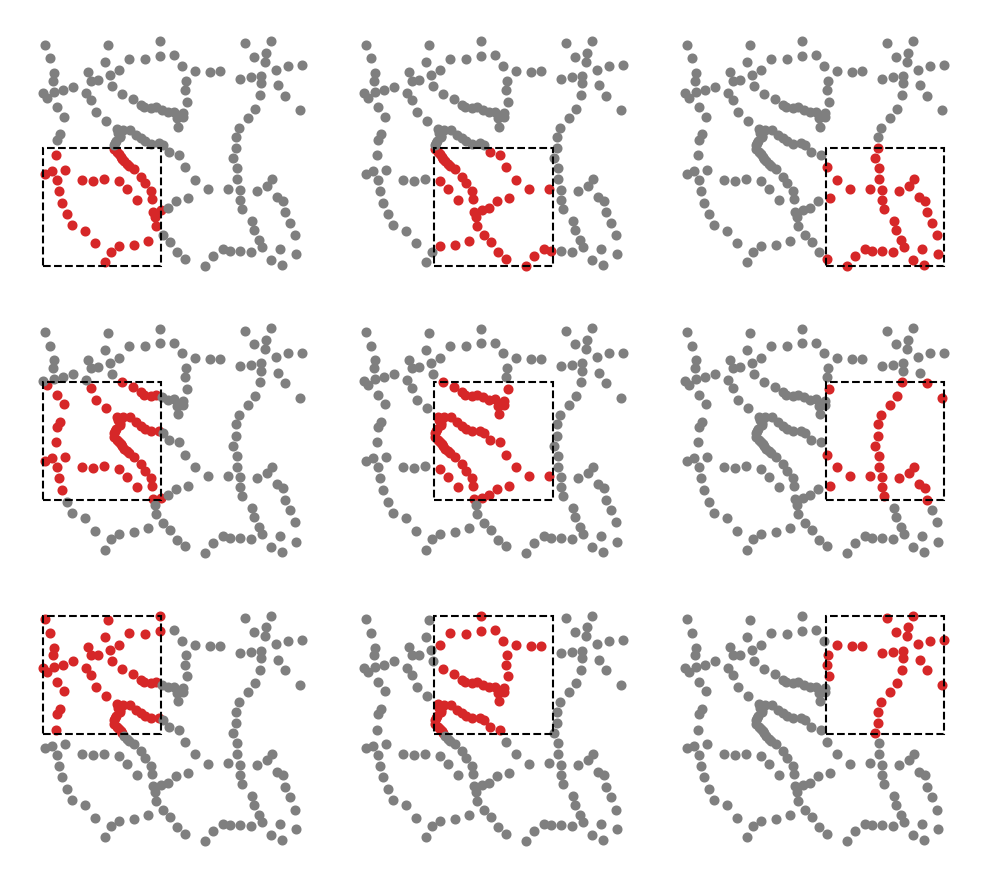

In [17]:
ncols = 3
nrows = int(np.ceil(n_windows / ncols))
figsize = (3.33, 1 * nrows)
size = 2


fig, axes = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=figsize, sharex=True, sharey=True
)
axes = axes.ravel()

for i in range(n_windows):
    ax = axes[i]
    window = indices[i]
    easting, northing = centers[0][i], centers[1][i]
    not_window = [i for i in np.arange(sources[0].size) if i not in window]
    ax.scatter(sources[0][window], sources[1][window], c="C3", s=size)
    ax.scatter(sources[0][not_window], sources[1][not_window], c="C7", s=size)
    rectangle = Rectangle(
        xy=(easting - window_size / 2, northing - window_size / 2),
        width=window_size,
        height=window_size,
        fill=False,
        linewidth=0.5,
        linestyle="--",
    )
    ax.add_patch(rectangle)
    ax.set_aspect("equal")
    ax.axis("off")

plt.tight_layout()
plt.savefig(
    Path("..") / "manuscript" / "figs" / "svg" / "gradient-boosting-windows.svg"
)
plt.show()